# Traspilazione

In [ ]:
import ast
from textwrap import indent
from operator import add, mul

from IPython.display import Javascript

from liblet import ANTLR, AnnotatedTreeWalker, Tree

## Uso di `AnnotatedTreeWalker`

Una breve introduzione all'[AnnotatedTreeWalker](https://liblet.readthedocs.io/en/v1.2.3-beta/api.html?highlight=annotatedtreewalker#liblet.antlr.AnnotatedTreeWalker): un esempio con un AST che rappresenta una espressione aritmetica su interi.

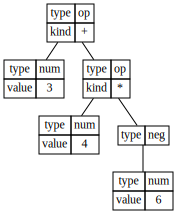

In [ ]:
atree = Tree.from_lol(
    [{'type': 'op', 'kind': '+'},
        [{'type': 'num', 'value': 3}], 
        [{'type': 'op', 'kind': '*'},
            [{'type': 'num', 'value': 4}],
            [{'type': 'neg'}, [{'type': 'num', 'value': 6}]]
        ]
    ])
atree

In [ ]:
# va creato usanto la chiave usata per distinguere i nodi

expreval = AnnotatedTreeWalker('type')

TREE_CATCHALL: {'type': 'op', 'kind': '+'}
TREE_CATCHALL: {'type': 'num', 'value': 3}
TREE_CATCHALL: {'type': 'op', 'kind': '*'}
TREE_CATCHALL: {'type': 'num', 'value': 4}
TREE_CATCHALL: {'type': 'neg'}
TREE_CATCHALL: {'type': 'num', 'value': 6}


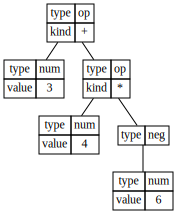

In [ ]:
# appena creato usa TREE_CATCHALL per tutti i nodi

expreval(atree)

In [ ]:
# si definiscono man mano i nodi

@expreval.register
def num(visit, tree):
    return int(tree.root['value'])

@expreval.register
def neg(visit, tree):
    return -visit(tree.children[0])

KIND2OP = {
    '+': add,
    '*': mul
}

@expreval.register
def op(visit, tree):
    l, r = tree.children
    return KIND2OP[tree.root['kind']](visit(l),  visit(r))

In [ ]:
# infine valuta l'espressione

expreval(atree)    

-21

## Un linguaggio semplice

Iniziamo da un linguaggio semplice, con variabili di tipo intero, *scope* esclusivamente globale, e due sole strutture di controllo: la *selezione* e la *ripetizione* (ossia una iterazione controllata in cui il numero di itearti sia noto e fissato prima del suo inizio). Per chi sa cosa sono, questo linguaggio è in grado di esprimere tutte le funzioni *ricorsive primitive*, una conseguenza di questo fatto è che la computazione termina sempre.

Per consentire un embrione di I/O assumeremo che le variabili `INPUT<N>` (dove `<N>` è un intero) e `OUTPUT` siano già pre-dichiarate nell'ambiente d'esecuzione con l'ovvio significato: la prime conterranno l'*input* per il programma e, al termine dell'esecuzione, l'*interprete* emetterà il contenuto della seconda.

### Grammatica e parsing

In [ ]:
SimpleLang = ANTLR(r"""grammar SimpleLang;

program: stat+ ;

expr: '!' expr            #notExpr
    | expr '*' expr       #prodExpr
    | expr ('+'|'-') expr #binOpExpr
    | expr '==' expr      #equalityExpr
    | ID                  #varRefExpr
    | INT                 #intExpr
    | '(' expr ')'        #subExpr
    ;

stat: 'var' ID ('=' expr)? ';'                    #varDeclStat
    | 'if' expr 'then' stat+ ('else' stat+)? 'fi' #ifElseStat
    | 'repeat' expr 'times' stat+ 'done'          #repeatStat
    | ID '=' expr ';'                             #assignementStat
    ;

ID: LETTER (LETTER | [0-9])* ;
INT: [0-9]+ ;
WS: [ \t\n\r]+ -> skip ;
fragment
LETTER : [a-zA-Z] ;
""")

In [ ]:
source = """
var somma = 0;
var n = 0;
repeat INPUT0 times
    n = n + 1;
    if n == 3 then
        OUTPUT = 100;
    fi
    if n == 4 then
        OUTPUT = 0;
    else
        OUTPUT = 10;
    fi
    somma = somma + n;
done
OUTPUT = OUTPUT + somma;
"""

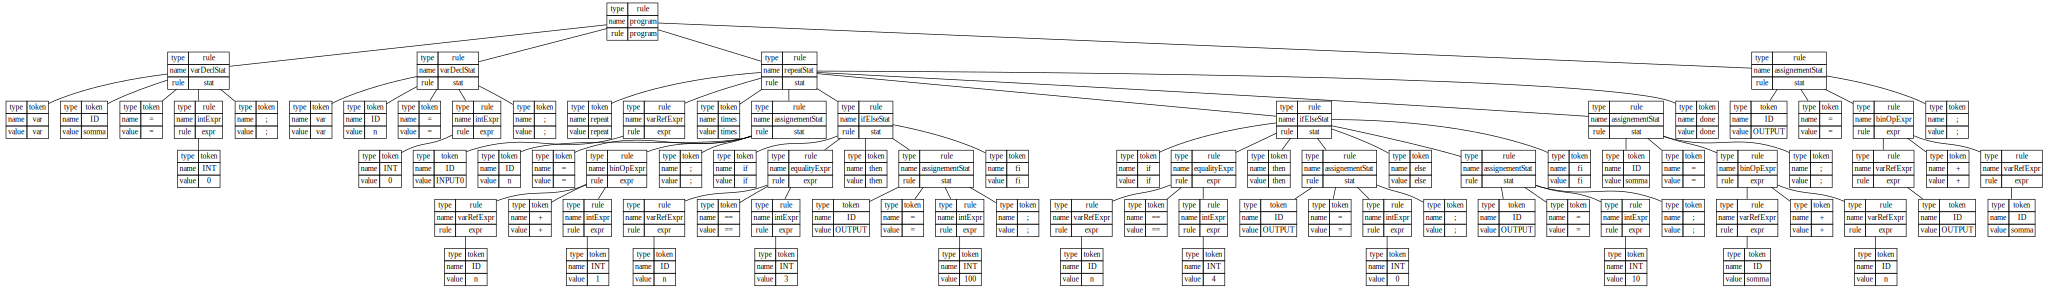

In [ ]:
ptree = SimpleLang.tree(source, 'program')
ptree

### Dal parse tree all'AST

In [ ]:
simple2ast = AnnotatedTreeWalker('name')

In [ ]:
@simple2ast.register
def intExpr(visit, ptree):
    return Tree({'type': 'intExpr', 'value': int(ptree.children[0].root['value'])})

@simple2ast.register
def binOpExpr(visit, ptree):
    left, op, right = ptree.children
    return Tree({'type': 'binOpExpr', 'op': op.root['name']}, [visit(left), visit(right)])

@simple2ast.register
def equalityExpr(visit, ptree):
    left, _, right = ptree.children
    return Tree({'type': 'binOpExpr', 'op': '=='}, [visit(left), visit(right)])

@simple2ast.register
def varRefExpr(visit, ptree):
    return Tree({'type': 'varRefExpr', 'varName': ptree.children[0].root['value']})

@simple2ast.register
def varDeclStat(visit, ptree):
    name = ptree.children[1].root['value']
    if len(ptree.children) == 5:
        return Tree({'type': 'varDeclInitStat', 'varName': name}, [visit(ptree.children[3])])
    else:
        return Tree({'type': 'varDeclStat', 'varName': name})

@simple2ast.register
def assignementStat(visit, ptree):
    name, _, right, _ = ptree.children
    return Tree({'type': 'assignementStat', 'varName': name.root['value']}, [visit(right)])

@simple2ast.register
def repeatStat(visit, ptree):
    _, expr, _, *stats, _ = ptree.children
    return Tree({'type': 'repeatStat'}, [visit(expr)] + [visit(stat) for stat in stats])

ELSE_ROOT = {'type': 'token', 'name': 'else', 'value': 'else'} 

@simple2ast.register
def ifElseStat(visit, ptree):
    _, cond, _, *stats, _ = ptree.children
    roots = [stat.root for stat in stats]
    try:
        elsePos = roots.index(ELSE_ROOT)
    except ValueError:
        elsePos = len(stats)
    return Tree({'type': 'ifElseStat', 'elsePos': elsePos}, 
                [visit(cond)] +
                [visit(stat) for stat in stats[:elsePos]] +
                [visit(stat) for stat in stats[elsePos + 1:]]
            )

@simple2ast.register
def program(visit, ptree):
    return Tree({'type': 'program'}, [visit(child) for child in ptree.children])

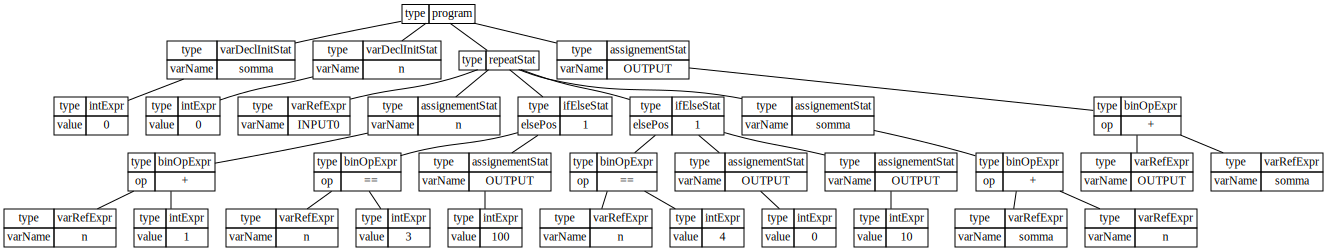

In [ ]:
atree = simple2ast(ptree)
atree

### Transpilazione verso Javascript

In [ ]:
simple2js = AnnotatedTreeWalker('type')

In [ ]:
@simple2js.register
def intExpr(visit, atree):
    return str(atree.root['value'])

@simple2js.register
def binOpExpr(visit, atree):
    return '{} {} {}'.format(visit(atree.children[0]), atree.root['op'], visit(atree.children[1]))

@simple2js.register
def varRefExpr(visit, atree):
    return atree.root['varName']

@simple2js.register
def varDeclStat(visit, atree):
    return 'let {};'.format(atree.root['varName'])

@simple2js.register
def varDeclInitStat(visit, atree):
    return 'let {} = {};'.format(atree.root['varName'], visit(atree.children[0]))

@simple2js.register
def ifElseStat(visit, atree):
    elsePos = atree.root['elsePos']
    stats = atree.children[1:]
    test = visit(atree.children[0])
    body = indent('\n'.join(visit(stat) for stat in stats[:elsePos]), '\t')
    orelse = indent('\n'.join(visit(stat) for stat in stats[elsePos:]), '\t')
    orelse = 'else {{\n{}\n}}'.format(orelse) if orelse != '' else ''
    return 'if ({}) {{\n{}\n}} {}'.format(test, body, orelse)

@simple2js.register
def repeatStat(visit, atree):
    count, *stats = atree.children
    stats = indent('\n'.join(visit(stat) for stat in stats), '\t')
    return 'for (let rv = 0; rv < {}; rv++) {{\n{}\n}}'.format(visit(atree.children[0]), stats) 

@simple2js.register
def assignementStat(visit, atree):
    return '{} = {};'.format(atree.root['varName'], visit(atree.children[0]))

@simple2js.register
def program(visit, atree):
    return '\n'.join(visit(child) for child in atree.children)

In [ ]:
code = simple2js(atree)
print(code)

let somma = 0;
let n = 0;
for (let rv = 0; rv < INPUT0; rv++) {
	n = n + 1;
	if (n == 3) {
		OUTPUT = 100;
	} 
	if (n == 4) {
		OUTPUT = 0;
	} else {
		OUTPUT = 10;
	}
	somma = somma + n;
}
OUTPUT = OUTPUT + somma;


### E l'input/output?

Facendo una analisi successiva al primo passo di transpilazione

In [ ]:
SEEN_INPUT_VARS = set()

def geninput(atree):
    if atree.root['type'] == 'varRefExpr':
        name = atree.root['varName']
        if name.startswith('INPUT'): SEEN_INPUT_VARS.add(name)
    else:
        for child in atree.children: geninput(child)
        
geninput(atree)

INPUT_JS = '\n'.join('let {} = window.prompt("{}");'.format(name, name) for name in SEEN_INPUT_VARS)
print(INPUT_JS)

let INPUT0 = window.prompt("INPUT0");


In [ ]:
code_withio = '\n'.join(['let OUTPUT = 0;', INPUT_JS, code, 'window.alert("OUTPUT " + OUTPUT)'])
print(code_withio)

let OUTPUT = 0;
let INPUT0 = window.prompt("INPUT0");
let somma = 0;
let n = 0;
for (let rv = 0; rv < INPUT0; rv++) {
	n = n + 1;
	if (n == 3) {
		OUTPUT = 100;
	} 
	if (n == 4) {
		OUTPUT = 0;
	} else {
		OUTPUT = 10;
	}
	somma = somma + n;
}
OUTPUT = OUTPUT + somma;
window.alert("OUTPUT " + OUTPUT)


Oppure svolgendo l'analisi e l'aggiunta del codice durante la transpilazione

In [ ]:
SEEN_INPUT_VARS = set()

@simple2js.register
def varRefExpr(visit, atree):
    name = atree.root['varName']
    if name.startswith('INPUT'): SEEN_INPUT_VARS.add(name)
    return name

@simple2js.register
def program(visit, atree):
    code = '\n'.join(visit(child) for child in atree.children)
    inputs = '\n'.join('let {} = window.prompt("{}");'.format(name, name) for name in SEEN_INPUT_VARS)
    return '\n'.join(['let OUTPUT = 0;', inputs, code, 'window.alert("OUTPUT " + OUTPUT)'])

code = simple2js(atree)
print(code)

let OUTPUT = 0;
let INPUT0 = window.prompt("INPUT0");
let somma = 0;
let n = 0;
for (let rv = 0; rv < INPUT0; rv++) {
	n = n + 1;
	if (n == 3) {
		OUTPUT = 100;
	} 
	if (n == 4) {
		OUTPUT = 0;
	} else {
		OUTPUT = 10;
	}
	somma = somma + n;
}
OUTPUT = OUTPUT + somma;
window.alert("OUTPUT " + OUTPUT)


### Esecueione

Per eseguire basta togliere il commento dalla prossima cella.

In [ ]:
# Javascript(code_withio)

## Gli AST (nativi) di Python

### Dal sorgente all'AST e sua esplorazione

Si può passare da un *sorgente* all'AST con [parse](https://docs.python.org/3/library/ast.html#ast.parse), qui usiamo `mode = 'eval'` perché il sorgente è una *espressione*.

In [ ]:
pysource = '1 + 3 * 4'

In [ ]:
atree = ast.parse(pysource, mode = 'eval')
atree

In [ ]:
# come stringa

ast.dump(atree)

'Expression(body=BinOp(left=Num(n=1), op=Add(), right=BinOp(left=Num(n=3), op=Mult(), right=Num(n=4))))'

In [ ]:
# visualizzato come Tree

def ast2tree(node):
    if not isinstance(node, ast.AST):
        return Tree({'type': 'token', 'value': node})
    else:
        return Tree({'type': 'ast', 'name': node.__class__.__name__}, 
            [ Tree(name, [ast2tree(v) for v in (value if isinstance(value, list) else [value])])
                for name, value in ast.iter_fields(node)
            ]     
        )                

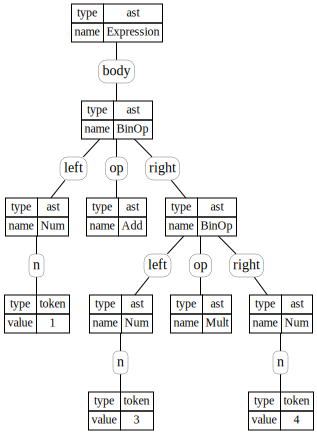

In [ ]:
ast2tree(atree)

### Compilazione ed esecuzione dell'AST

Un AST può essere compilato con [compile](https://docs.python.org/3/library/functions.html#compile) e quindi, essendo una *espressione*, essere eseguito con [eval](https://docs.python.org/3/library/functions.html#eval).

In [ ]:
# di nuovo 'eval' percché è una espressione

code  = compile(atree, filename = '<ast>', mode = 'eval')

In [ ]:
# per valutare si usa eval perché è una espressione
eval(code)

13

### Costruzione "manuale" di un AST

Per una descrizione dei nodi si veda:

* l'[Abstract Grammar](https://docs.python.org/3/library/ast.html#abstract-grammar) riportata nella documentazione ufficiale e
* la sezione [Meet the Nodes](https://greentreesnakes.readthedocs.io/en/latest/nodes.html) della documentazione "Green Tree Snakes".

In [ ]:
# un esempio: l'espressione tra liste [1, 2]  + ['three']

atree = ast.Expression(
    body = ast.BinOp(
        left = ast.List([ast.Num(1), ast.Num(2)], ctx = ast.Load()),
        op = ast.Add(),
        right = ast.List([ast.Str('three')], ctx = ast.Load())
    )
    
)

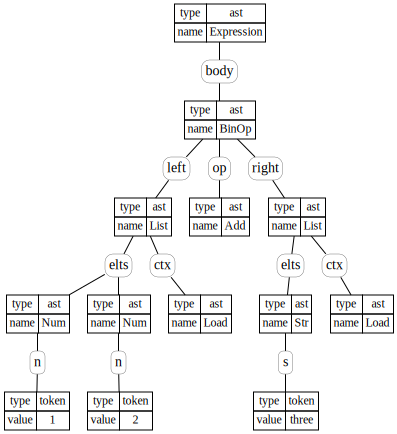

In [ ]:
ast2tree(atree)

Trattandosi di codice costruito a mano, è necessario sistemare i numeri di linea e colonna con [fix_missing_locations](https://docs.python.org/3/library/ast.html#ast.fix_missing_locations) che decora i nodi dell'AST con le informazioni aggiuntive.

In [ ]:
ast.fix_missing_locations(atree)

In [ ]:
# compilazione ed esecuzione

code  = compile(atree, filename = '<ast>', mode = 'eval')
eval(code)

[1, 2, 'three']

## Transpilazione verso gli AST (nativi) di Python

### Costruzione dell'AST Python

In [ ]:
simple2py = AnnotatedTreeWalker('type')

In [ ]:
@simple2py.register
def intExpr(visit, atree):
    return ast.Num(n = atree.root['value'])

@simple2py.register
def binOpExpr(visit, atree):
    left = visit(atree.children[0])
    right = visit(atree.children[1])
    if atree.root['op'] == '+':
        return ast.BinOp(left = left, op = ast.Add(), right = right)
    elif atree.root['op'] == '-':
        return ast.BinOp(left = left, op = ast.Sub(), right = right)
    elif atree.root['op'] == '==':
        return ast.Compare(left = left, ops=[ast.Eq()], comparators = [right])

@simple2py.register
def varRefExpr(visit, atree):
    return ast.Name(id = atree.root['varName'], ctx = ast.Load())

@simple2py.register
def varDeclStat(visit, atree):
    return ast.Assign(targets = [ast.Name(id = atree.root['varName'], ctx = ast.Store())], value = ast.Num(n = 0))

@simple2py.register
def varDeclInitStat(visit, atree):
    return ast.Assign(targets = [ast.Name(id = atree.root['varName'], ctx = ast.Store())], value = visit(atree.children[0]))

@simple2py.register
def repeatStat(visit, atree):
    count, *stats = atree.children
    return ast.For(
        target = ast.Name(id = 'rv', ctx = ast.Store()), 
        iter = ast.Call( 
                    func = ast.Name(id = 'range', ctx = ast.Load()), 
                    args = [visit(count)], 
                    keywords = []
                ), 
        body = [visit(stat) for stat in stats], 
        orelse = []
    )

@simple2py.register
def ifElseStat(visit, atree):
    elsePos = atree.root['elsePos']
    stats = atree.children[1:]
    return ast.If(
        test = visit(atree.children[0]), 
        body = [visit(stat) for stat in stats[:elsePos]], 
        orelse = [visit(stat) for stat in stats[elsePos:]], 
    )

@simple2py.register
def assignementStat(visit, atree):
    return ast.Assign(targets = [ast.Name(id = atree.root['varName'], ctx = ast.Store())], value = visit(atree.children[0]))

@simple2py.register
def program(visit, atree):
    return ast.Module(body = [visit(child) for child in atree.children])

In [ ]:
# costruzione dell'AST Python 

pyast = simple2py(simple2ast(SimpleLang.tree(source, 'program')))

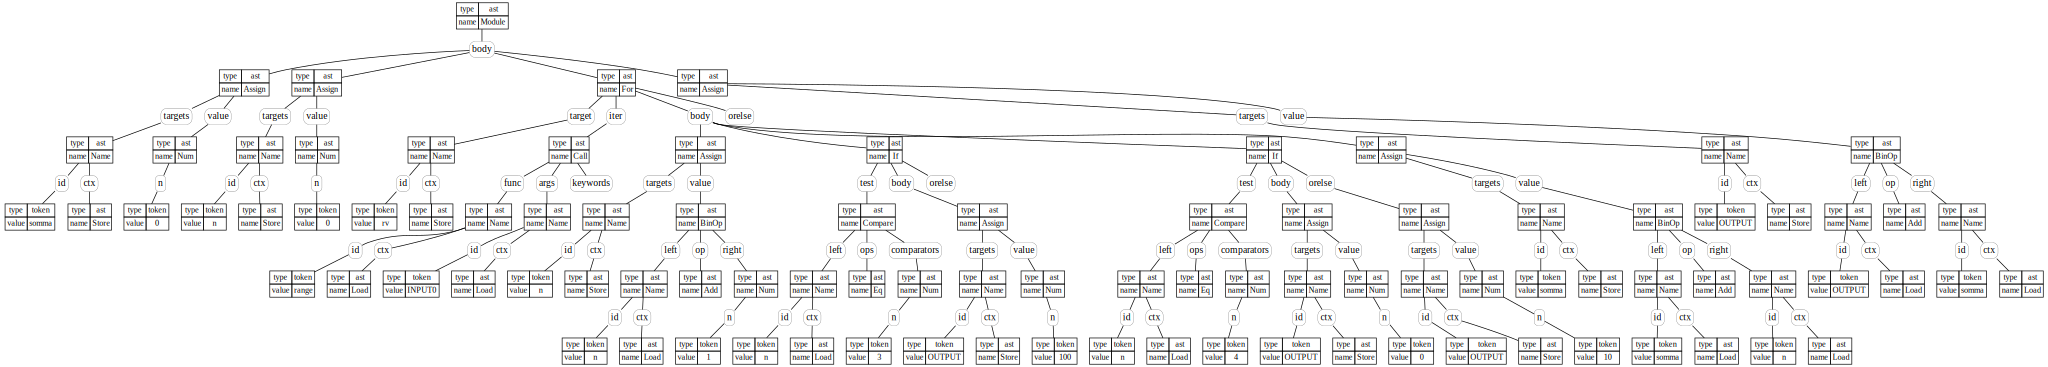

In [ ]:
ast2tree(pyast)

### Esecuzione

Per prima cosa, si sistemano i numeri di linea e si compila, in questo caso con `mode = 'exec'` perché il codice è uno *statement* non più una espressione.

In [ ]:
ast.fix_missing_locations(pyast)

In [ ]:
code  = compile(pyast, filename = '<ast>', mode = 'exec')

Prima dell'esecuzione con [exec](https://docs.python.org/3/library/functions.html#exec) è necessario fornire il dizionario delle variabili locali, dove mettere l'*input*:

In [ ]:
localvars = {'INPUT0': 10}

In [ ]:
# esecuzione

exec(code, globals(), localvars)

In [ ]:
# reperimento dell'output

localvars['OUTPUT']

65